In [4]:
import numpy as np
import sys
sys.path.append('/home/shoshi/MITgcm_c68p/MITgcm/utils/python/MITgcmutils')

from MITgcmutils import rdmds
import matplotlib.pyplot as plt

## Create patchface functions to shift between different map views

In [2]:
### compact --> worldmap view ###

# taken from /home/atnguyen/python/read_simple_ocellc90global.py
def patchface3D(fldin,nx,nz):

    print(nz)
    #add a new dimension in case it's only 2d field:
    if nz == 1:
        fldin=fldin[np.newaxis, :, :]

    #defining a big face:
    a=np.zeros((nz,4*nx,4*nx))       #(50,270,360)

    #face1
    tmp=fldin[:,0:3*nx,0:nx]        #(50,270,90)
    a[:,0:3*nx,0:nx]=tmp

    #face2
    tmp=fldin[:,(3*nx):(6*nx),0:nx] #(50, 270,90)
    a[:,0:3*nx,nx:2*nx]=tmp

    #face3
    tmp=fldin[:,(6*nx):(7*nx),0:nx] #(50, 90, 90)
    tmp=np.transpose(tmp, (1,2,0))  #(90, 90, 50)
    ##syntax to rotate ccw:
    tmp1=list(zip(*tmp[::-1]))
    tmp1=np.asarray(tmp1)
    tmp1=np.transpose(tmp1,[2,0,1]) #(50, 90, 90)
    a[:,3*nx:4*nx,0:nx]=tmp1

    #face4
    tmp=np.reshape(fldin[:,7*nx:10*nx,0:nx],[nz,nx,3*nx]) #(50,90,270)
    tmp=np.transpose(tmp, (1,2,0))
    print(tmp.shape)                                      #(90,270,50)
    #syntax to rotate cw:
    tmp1=list(zip(*tmp))[::-1]      #type is <class 'list'>
    tmp1=np.asarray(tmp1)           #type <class 'numpy.ndarray'>, shape (270,90,50)
    tmp1=np.transpose(tmp1,[2,0,1]) #(50,270,90)
    a[:,0:3*nx,2*nx:3*nx]=tmp1

    #face5
    tmp=np.reshape(fldin[:,10*nx:13*nx,0:nx],[nz,nx,3*nx]) #(50,90,270)
    tmp=np.transpose(tmp, (1,2,0))                         #(90,270,50)
    tmp1=list(zip(*tmp))[::-1]      #type is <class 'zip'> --> <class 'list'>
    tmp1=np.asarray(tmp1)           #type <class 'numpy.ndarray'>, shape (270,90,50)
    tmp1=np.transpose(tmp1,[2,0,1]) #(50,270,90)
    a[:,0:3*nx,3*nx:4*nx]=tmp1

    return a


In [79]:
# rotate faces
# translated from /home/atnguyen/llc270/global/matlab/simple_ctd/MITprof_toolbox/sym_g_mod.m

def sym_g_mod(field_in, sym_in):
    field_out = field_in
    for icur in range(sym_in-4):
        field_out = np.flip(np.transpose(field_out, (0, 2, 1)), axis=2)

    return field_out
    

In [99]:
### worldmap view --> 5 faces ###
# translated from /home/atnguyen/matlab/atn_tools/patchface3D.m

def patchface3D_wrld_to_5f(array_in):

    nz, ny, nx = np.shape(array_in)
    nx = int(nx/4)
    faces = dict()
    
    # face 1
    faces[1] = array_in[:,:3*nx,:nx]
    
    # face 2
    faces[2] = array_in[:,:3*nx,nx:2*nx]
    
    # face 4
    face4 = array_in[:,:3*nx,2*nx:3*nx]
    faces[4] = sym_g_mod(face4, 5)
    
    # face 5
    face5 = array_in[:,:3*nx,3*nx:4*nx]
    faces[5] = sym_g_mod(face5, 5)
    
    # face 3
    face3 = array_in[:,3*nx:4*nx,:nx]
    faces[3] = sym_g_mod(face3, 7)

    return faces
    

In [9]:
grid_dir='/scratch/shoshi/MITgcm_c68p/llc90/run_obsfit_pk0000205956/'
hfc90 = rdmds(grid_dir+'hFacC')#, lev=0)
hfc90[hfc90!=0]=np.nan
np.shape(hfc90)

(50, 1170, 90)

50
(90, 270, 50)


Text(0.5, 1.0, 'worldmap view')

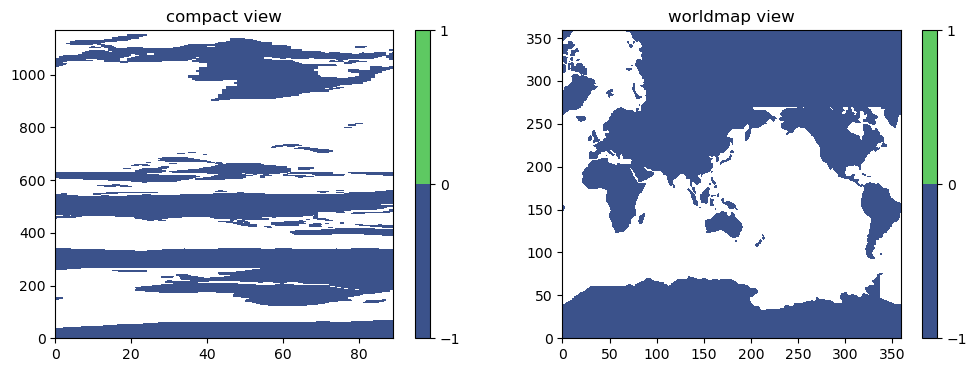

In [94]:
nx=90
ny=nx*13
nz=50

fldin=hfc90
hfc_big=patchface3D(fldin,nx,nz)
clevels = np.arange(-1, 2, 1)
plt.figure(figsize=(12,4))
plt.subplot(121)
clevels = np.arange(-1, 2, 1)
plt.contourf(hfc90[0,:,:],levels=clevels)
plt.colorbar()
plt.title('compact view')


plt.subplot(122)
plt.contourf(hfc_big[0,:,:],levels=clevels)
plt.colorbar()
plt.title('worldmap view')


In [97]:
hfc_big # worldmap view

hfc_5f = patchface3D_wrld_to_5f(hfc_big)

# for i in range(1,6):
#     plt.figure()
#     plt.title('5 face view')
#     plt.contourf(hfc_5f[i][0,:,:],levels=clevels)
#     plt.colorbar()



## data processing
translated from /home/atnguyen/llc270/global/matlab/simple_ctd/

step02:
- xc and yc are reshaped from compact (nx, 13*nx) to worldmap (4*nx, 4*nx)
- prof_point/nearest_swot_index is computed relative to worldmap view
  
step04
- Line 43/44: xc and yc are turned from (4*nx, 4*nx) to 5-face view. Use patchface3D_wrld_to_5f. This is "direction 3" in matlab script patchface3D.m 
- FOR face = 1..5: Do the [X,Y]C[11,NINJ] routine
- Line 68: (I think — convince yourself) sneakily turn each [X,Y]C[11,NINJ] field from 5-face  to compact
- Line 69: Change each field from compact to worldmap (she has done so in her python function)
- Line 70: Use the prof_point (which was created relative to worldmap view) to grab the index from each field, which are now properly in worldmap view.